# Models Comparison for TinyML

In [21]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs

warnings.filterwarnings('ignore')

In [22]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [28]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [29]:
print(X.shape)

(1400, 5)


In [30]:
X = np.concatenate((X[:200], X[600:800], X[1200:]), axis=0)
y = np.concatenate((y[:200], y[600:800], y[1200:]), axis=0)

In [31]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [35]:
print(X_test)

[[  21  102  100  220    0]
 [ 100  110  101 1010    0]
 [ 102  121  111 1102    0]
 [ 111  122  112 1112    0]
 [ 111  122  120 1122    0]
 [ 100  111  102 1002    0]
 [ 102  120  111 1100    0]
 [ 100  111  101 1001    0]
 [ 111  122  112 1111    0]
 [  21  102  100  221    0]
 [  21  102  101  221    0]
 [ 112  201  121 1200    0]
 [ 110  120  111 1101    0]
 [  21  101  100  212    0]
 [  21  102  100  220    0]
 [  22  111  102 1001    0]
 [ 122  202  200 2000    0]
 [ 120  201  121 1210    0]
 [ 101  120  110 1021    0]
 [ 101  120  110 1021    0]
 [  22  110  101 1001    0]
 [ 112  201  122 1210    0]
 [ 121  202  122 1221    0]
 [ 100  111  101 1001    0]
 [ 121  210  200 1222    0]
 [ 122  210  201 2002    0]
 [ 112  200  120 1122    0]
 [ 110  122  120 1121  212]
 [ 112  200  120 1200    0]
 [ 121  202  122 1222    0]
 [ 102  121  111 1100    0]
 [ 111  201  122 1200    0]
 [  21  102  100  221    0]
 [ 120  210  201 1221    0]
 [  22  110  101 1000    0]
 [ 110  121  111 110

## Model Spotting

In [36]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [37]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [38]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,72 0,06
LR - 0,79 0,07
CART - 0,93 0,03
SVC - 0,91 0,04
RF - 0,94 0,02


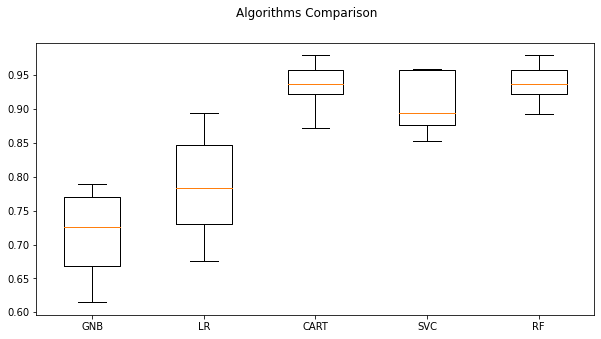

In [39]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Valutazione modelli sul Test Set

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.95      0.45      0.61        40
           1       0.49      0.80      0.61        40
           2       0.81      0.72      0.76        40

    accuracy                           0.66       120
   macro avg       0.75      0.66      0.66       120
weighted avg       0.75      0.66      0.66       120

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.97      0.70      0.81        40
           1       0.67      0.82      0.74        40
           2       0.86      0.90      0.88        40

    accuracy                           0.81       120
   macro avg       0.83      0.81      0.81       120
weighted avg       0.83      0.81      0.81       120

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.93

# Valutazione Inferance Rate medio (|X_test| = 100)

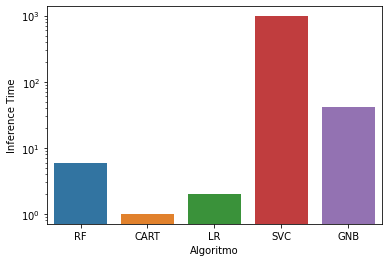

In [41]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

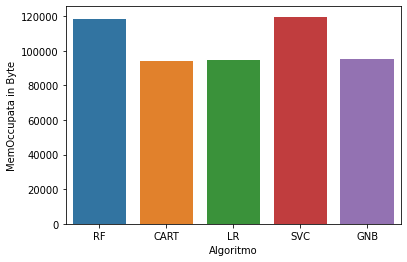

In [42]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [43]:
learn_rate = 0.001
def getNetwork(): 
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [17]:
EPOCHS = 500
BATCH_SIZE = 5
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
87/87 [==============================] - 0s 359us/step - loss: 1.0714 - accuracy: 0.6458
Epoch 2/500
87/87 [==============================] - 0s 357us/step - loss: 0.6487 - accuracy: 0.7801
Epoch 3/500
87/87 [==============================] - 0s 342us/step - loss: 0.5662 - accuracy: 0.7894
Epoch 4/500
87/87 [==============================] - 0s 363us/step - loss: 0.5

87/87 [==============================] - 0s 337us/step - loss: 0.2616 - accuracy: 0.8935
Epoch 75/500
87/87 [==============================] - 0s 335us/step - loss: 0.2612 - accuracy: 0.8935
Epoch 76/500
87/87 [==============================] - 0s 336us/step - loss: 0.2685 - accuracy: 0.8819
Epoch 77/500
87/87 [==============================] - 0s 330us/step - loss: 0.2684 - accuracy: 0.8935
Epoch 78/500
87/87 [==============================] - 0s 339us/step - loss: 0.2666 - accuracy: 0.8981
Epoch 79/500
87/87 [==============================] - 0s 374us/step - loss: 0.2720 - accuracy: 0.8843
Epoch 80/500
87/87 [==============================] - 0s 359us/step - loss: 0.2623 - accuracy: 0.8958
Epoch 81/500
87/87 [==============================] - 0s 340us/step - loss: 0.2606 - accuracy: 0.8866
Epoch 82/500
87/87 [==============================] - 0s 358us/step - loss: 0.2644 - accuracy: 0.8912
Epoch 83/500
87/87 [==============================] - 0s 358us/step - loss: 0.2693 - accuracy: 

KeyboardInterrupt: 

# Train and Test

In [44]:
EPOCHS = 750
BATCH_SIZE = 5

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred))

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1536      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/750
72/72 [==============================] - 0s 1ms/step - loss: 1.0525 - accuracy: 0.6806 - val_loss: 0.7165 - val_accuracy: 0.8083
Epoch 2/750
72/72 [==============================] - 0s 543us/step - loss: 0.6842 - accuracy: 0.7750 - val_loss: 0.5988 - val_accuracy: 0.8333
Epoch 3/750
72/72 [==============================] - 0s 527us/step - loss: 0.6075 - accuracy: 0.7

Epoch 53/750
72/72 [==============================] - 0s 505us/step - loss: 0.3388 - accuracy: 0.8611 - val_loss: 0.2769 - val_accuracy: 0.8500
Epoch 54/750
72/72 [==============================] - 0s 499us/step - loss: 0.3394 - accuracy: 0.8667 - val_loss: 0.2857 - val_accuracy: 0.9167
Epoch 55/750
72/72 [==============================] - 0s 531us/step - loss: 0.3314 - accuracy: 0.8583 - val_loss: 0.2492 - val_accuracy: 0.8833
Epoch 56/750
72/72 [==============================] - 0s 512us/step - loss: 0.3405 - accuracy: 0.8694 - val_loss: 0.2674 - val_accuracy: 0.9167
Epoch 57/750
72/72 [==============================] - 0s 509us/step - loss: 0.3303 - accuracy: 0.8583 - val_loss: 0.2724 - val_accuracy: 0.8833
Epoch 58/750
72/72 [==============================] - 0s 505us/step - loss: 0.3371 - accuracy: 0.8611 - val_loss: 0.2739 - val_accuracy: 0.9167
Epoch 59/750
72/72 [==============================] - 0s 508us/step - loss: 0.3251 - accuracy: 0.8583 - val_loss: 0.2679 - val_accuracy:

Epoch 110/750
72/72 [==============================] - 0s 508us/step - loss: 0.2776 - accuracy: 0.8917 - val_loss: 0.2167 - val_accuracy: 0.9250
Epoch 111/750
72/72 [==============================] - 0s 517us/step - loss: 0.2742 - accuracy: 0.8778 - val_loss: 0.2106 - val_accuracy: 0.9167
Epoch 112/750
72/72 [==============================] - 0s 508us/step - loss: 0.2770 - accuracy: 0.8833 - val_loss: 0.2111 - val_accuracy: 0.9333
Epoch 113/750
72/72 [==============================] - 0s 512us/step - loss: 0.2716 - accuracy: 0.8861 - val_loss: 0.2251 - val_accuracy: 0.9167
Epoch 114/750
72/72 [==============================] - 0s 526us/step - loss: 0.2689 - accuracy: 0.8972 - val_loss: 0.2141 - val_accuracy: 0.9167
Epoch 115/750
72/72 [==============================] - 0s 532us/step - loss: 0.2707 - accuracy: 0.8750 - val_loss: 0.2040 - val_accuracy: 0.9250
Epoch 116/750
72/72 [==============================] - 0s 535us/step - loss: 0.2851 - accuracy: 0.8889 - val_loss: 0.2328 - val_ac

72/72 [==============================] - 0s 498us/step - loss: 0.2437 - accuracy: 0.8944 - val_loss: 0.1911 - val_accuracy: 0.9250
Epoch 167/750
72/72 [==============================] - 0s 508us/step - loss: 0.2443 - accuracy: 0.9083 - val_loss: 0.1944 - val_accuracy: 0.9417
Epoch 168/750
72/72 [==============================] - 0s 501us/step - loss: 0.2529 - accuracy: 0.8917 - val_loss: 0.1804 - val_accuracy: 0.9333
Epoch 169/750
72/72 [==============================] - 0s 515us/step - loss: 0.2471 - accuracy: 0.9194 - val_loss: 0.1841 - val_accuracy: 0.9417
Epoch 170/750
72/72 [==============================] - 0s 523us/step - loss: 0.2483 - accuracy: 0.9028 - val_loss: 0.1828 - val_accuracy: 0.9333
Epoch 171/750
72/72 [==============================] - 0s 520us/step - loss: 0.2472 - accuracy: 0.9083 - val_loss: 0.1932 - val_accuracy: 0.9417
Epoch 172/750
72/72 [==============================] - 0s 484us/step - loss: 0.2647 - accuracy: 0.8861 - val_loss: 0.1846 - val_accuracy: 0.9333

72/72 [==============================] - 0s 527us/step - loss: 0.2334 - accuracy: 0.9056 - val_loss: 0.1828 - val_accuracy: 0.9417
Epoch 223/750
72/72 [==============================] - 0s 529us/step - loss: 0.2288 - accuracy: 0.9083 - val_loss: 0.1967 - val_accuracy: 0.9417
Epoch 224/750
72/72 [==============================] - 0s 508us/step - loss: 0.2302 - accuracy: 0.8944 - val_loss: 0.1982 - val_accuracy: 0.9333
Epoch 225/750
72/72 [==============================] - 0s 512us/step - loss: 0.2271 - accuracy: 0.9194 - val_loss: 0.1772 - val_accuracy: 0.9500
Epoch 226/750
72/72 [==============================] - 0s 522us/step - loss: 0.2275 - accuracy: 0.9111 - val_loss: 0.1853 - val_accuracy: 0.9583
Epoch 227/750
72/72 [==============================] - 0s 553us/step - loss: 0.2278 - accuracy: 0.9167 - val_loss: 0.1802 - val_accuracy: 0.9417
Epoch 228/750
72/72 [==============================] - 0s 523us/step - loss: 0.2342 - accuracy: 0.9083 - val_loss: 0.1811 - val_accuracy: 0.9500

72/72 [==============================] - 0s 528us/step - loss: 0.2057 - accuracy: 0.9194 - val_loss: 0.1639 - val_accuracy: 0.9417
Epoch 279/750
72/72 [==============================] - 0s 517us/step - loss: 0.2120 - accuracy: 0.9167 - val_loss: 0.1972 - val_accuracy: 0.9250
Epoch 280/750
72/72 [==============================] - 0s 498us/step - loss: 0.2036 - accuracy: 0.9278 - val_loss: 0.2261 - val_accuracy: 0.9083
Epoch 281/750
72/72 [==============================] - 0s 495us/step - loss: 0.2118 - accuracy: 0.9139 - val_loss: 0.1899 - val_accuracy: 0.9417
Epoch 282/750
72/72 [==============================] - 0s 482us/step - loss: 0.2035 - accuracy: 0.9111 - val_loss: 0.1803 - val_accuracy: 0.9417
Epoch 283/750
72/72 [==============================] - 0s 488us/step - loss: 0.2063 - accuracy: 0.9222 - val_loss: 0.1700 - val_accuracy: 0.9500
Epoch 284/750
72/72 [==============================] - 0s 487us/step - loss: 0.2155 - accuracy: 0.9194 - val_loss: 0.1812 - val_accuracy: 0.9417

72/72 [==============================] - 0s 508us/step - loss: 0.2088 - accuracy: 0.9222 - val_loss: 0.1858 - val_accuracy: 0.9500
Epoch 335/750
72/72 [==============================] - 0s 524us/step - loss: 0.2022 - accuracy: 0.9306 - val_loss: 0.1718 - val_accuracy: 0.9583
Epoch 336/750
72/72 [==============================] - 0s 508us/step - loss: 0.2246 - accuracy: 0.8972 - val_loss: 0.2078 - val_accuracy: 0.9250
Epoch 337/750
72/72 [==============================] - 0s 506us/step - loss: 0.2042 - accuracy: 0.9333 - val_loss: 0.1829 - val_accuracy: 0.9333
Epoch 338/750
72/72 [==============================] - 0s 501us/step - loss: 0.2181 - accuracy: 0.9222 - val_loss: 0.1831 - val_accuracy: 0.9500
Epoch 339/750
72/72 [==============================] - 0s 525us/step - loss: 0.2189 - accuracy: 0.8889 - val_loss: 0.1661 - val_accuracy: 0.9583
Epoch 340/750
72/72 [==============================] - 0s 506us/step - loss: 0.1961 - accuracy: 0.9278 - val_loss: 0.1946 - val_accuracy: 0.9417

72/72 [==============================] - 0s 508us/step - loss: 0.1960 - accuracy: 0.9333 - val_loss: 0.1668 - val_accuracy: 0.9417
Epoch 391/750
72/72 [==============================] - 0s 586us/step - loss: 0.1985 - accuracy: 0.9278 - val_loss: 0.1616 - val_accuracy: 0.9500
Epoch 392/750
72/72 [==============================] - 0s 521us/step - loss: 0.1883 - accuracy: 0.9306 - val_loss: 0.1766 - val_accuracy: 0.9333
Epoch 393/750
72/72 [==============================] - 0s 498us/step - loss: 0.1937 - accuracy: 0.9333 - val_loss: 0.2023 - val_accuracy: 0.9167
Epoch 394/750
72/72 [==============================] - 0s 514us/step - loss: 0.2045 - accuracy: 0.9139 - val_loss: 0.1745 - val_accuracy: 0.9500
Epoch 395/750
72/72 [==============================] - 0s 501us/step - loss: 0.1959 - accuracy: 0.9222 - val_loss: 0.2219 - val_accuracy: 0.9167
Epoch 396/750
72/72 [==============================] - 0s 506us/step - loss: 0.1985 - accuracy: 0.9167 - val_loss: 0.1696 - val_accuracy: 0.9500

72/72 [==============================] - 0s 500us/step - loss: 0.1886 - accuracy: 0.9222 - val_loss: 0.1882 - val_accuracy: 0.9250
Epoch 447/750
72/72 [==============================] - 0s 514us/step - loss: 0.1904 - accuracy: 0.9222 - val_loss: 0.1784 - val_accuracy: 0.9333
Epoch 448/750
72/72 [==============================] - 0s 502us/step - loss: 0.1936 - accuracy: 0.9333 - val_loss: 0.1761 - val_accuracy: 0.9250
Epoch 449/750
72/72 [==============================] - 0s 507us/step - loss: 0.1870 - accuracy: 0.9333 - val_loss: 0.1735 - val_accuracy: 0.9500
Epoch 450/750
72/72 [==============================] - 0s 501us/step - loss: 0.1970 - accuracy: 0.9222 - val_loss: 0.1766 - val_accuracy: 0.9250
Epoch 451/750
72/72 [==============================] - 0s 506us/step - loss: 0.1866 - accuracy: 0.9333 - val_loss: 0.1727 - val_accuracy: 0.9333
Epoch 452/750
72/72 [==============================] - 0s 493us/step - loss: 0.2021 - accuracy: 0.9194 - val_loss: 0.2003 - val_accuracy: 0.9167

72/72 [==============================] - 0s 528us/step - loss: 0.1786 - accuracy: 0.9250 - val_loss: 0.1699 - val_accuracy: 0.9250
Epoch 503/750
72/72 [==============================] - 0s 544us/step - loss: 0.2021 - accuracy: 0.9139 - val_loss: 0.1572 - val_accuracy: 0.9583
Epoch 504/750
72/72 [==============================] - 0s 524us/step - loss: 0.1950 - accuracy: 0.9222 - val_loss: 0.1607 - val_accuracy: 0.9333
Epoch 505/750
72/72 [==============================] - 0s 497us/step - loss: 0.1889 - accuracy: 0.9278 - val_loss: 0.1655 - val_accuracy: 0.9417
Epoch 506/750
72/72 [==============================] - 0s 534us/step - loss: 0.1783 - accuracy: 0.9278 - val_loss: 0.2267 - val_accuracy: 0.9167
Epoch 507/750
72/72 [==============================] - 0s 501us/step - loss: 0.1875 - accuracy: 0.9306 - val_loss: 0.1810 - val_accuracy: 0.9250
Epoch 508/750
72/72 [==============================] - 0s 495us/step - loss: 0.1796 - accuracy: 0.9361 - val_loss: 0.1740 - val_accuracy: 0.9333

72/72 [==============================] - 0s 538us/step - loss: 0.1989 - accuracy: 0.9250 - val_loss: 0.1630 - val_accuracy: 0.9583
Epoch 559/750
72/72 [==============================] - 0s 516us/step - loss: 0.1784 - accuracy: 0.9306 - val_loss: 0.1817 - val_accuracy: 0.9250
Epoch 560/750
72/72 [==============================] - 0s 513us/step - loss: 0.1845 - accuracy: 0.9222 - val_loss: 0.1942 - val_accuracy: 0.9250
Epoch 561/750
72/72 [==============================] - 0s 531us/step - loss: 0.1811 - accuracy: 0.9250 - val_loss: 0.1586 - val_accuracy: 0.9583
Epoch 562/750
72/72 [==============================] - 0s 522us/step - loss: 0.1774 - accuracy: 0.9417 - val_loss: 0.2348 - val_accuracy: 0.9000
Epoch 563/750
72/72 [==============================] - 0s 526us/step - loss: 0.1888 - accuracy: 0.9250 - val_loss: 0.1944 - val_accuracy: 0.9250
Epoch 564/750
72/72 [==============================] - 0s 514us/step - loss: 0.1877 - accuracy: 0.9333 - val_loss: 0.2440 - val_accuracy: 0.9167

72/72 [==============================] - 0s 572us/step - loss: 0.1758 - accuracy: 0.9250 - val_loss: 0.1556 - val_accuracy: 0.9500
Epoch 615/750
72/72 [==============================] - 0s 522us/step - loss: 0.1969 - accuracy: 0.9222 - val_loss: 0.1824 - val_accuracy: 0.9417
Epoch 616/750
72/72 [==============================] - 0s 499us/step - loss: 0.1862 - accuracy: 0.9306 - val_loss: 0.2271 - val_accuracy: 0.9250
Epoch 617/750
72/72 [==============================] - 0s 523us/step - loss: 0.1810 - accuracy: 0.9194 - val_loss: 0.1538 - val_accuracy: 0.9583
Epoch 618/750
72/72 [==============================] - 0s 498us/step - loss: 0.1875 - accuracy: 0.9194 - val_loss: 0.1606 - val_accuracy: 0.9583
Epoch 619/750
72/72 [==============================] - 0s 511us/step - loss: 0.1856 - accuracy: 0.9306 - val_loss: 0.1719 - val_accuracy: 0.9250
Epoch 620/750
72/72 [==============================] - 0s 561us/step - loss: 0.1787 - accuracy: 0.9306 - val_loss: 0.1709 - val_accuracy: 0.9333

72/72 [==============================] - 0s 512us/step - loss: 0.1802 - accuracy: 0.9333 - val_loss: 0.1682 - val_accuracy: 0.9500
Epoch 671/750
72/72 [==============================] - 0s 531us/step - loss: 0.1859 - accuracy: 0.9111 - val_loss: 0.2159 - val_accuracy: 0.9167
Epoch 672/750
72/72 [==============================] - 0s 517us/step - loss: 0.1789 - accuracy: 0.9333 - val_loss: 0.1631 - val_accuracy: 0.9500
Epoch 673/750
72/72 [==============================] - 0s 520us/step - loss: 0.1794 - accuracy: 0.9306 - val_loss: 0.1720 - val_accuracy: 0.9333
Epoch 674/750
72/72 [==============================] - 0s 519us/step - loss: 0.1657 - accuracy: 0.9417 - val_loss: 0.2288 - val_accuracy: 0.9417
Epoch 675/750
72/72 [==============================] - 0s 520us/step - loss: 0.1793 - accuracy: 0.9306 - val_loss: 0.2266 - val_accuracy: 0.9167
Epoch 676/750
72/72 [==============================] - 0s 542us/step - loss: 0.1996 - accuracy: 0.9250 - val_loss: 0.1866 - val_accuracy: 0.9250

72/72 [==============================] - 0s 507us/step - loss: 0.1739 - accuracy: 0.9389 - val_loss: 0.2172 - val_accuracy: 0.9000
Epoch 727/750
72/72 [==============================] - 0s 492us/step - loss: 0.1885 - accuracy: 0.9306 - val_loss: 0.2004 - val_accuracy: 0.9250
Epoch 728/750
72/72 [==============================] - 0s 479us/step - loss: 0.1747 - accuracy: 0.9278 - val_loss: 0.2449 - val_accuracy: 0.9333
Epoch 729/750
72/72 [==============================] - 0s 500us/step - loss: 0.1840 - accuracy: 0.9361 - val_loss: 0.2014 - val_accuracy: 0.9250
Epoch 730/750
72/72 [==============================] - 0s 495us/step - loss: 0.1694 - accuracy: 0.9306 - val_loss: 0.1903 - val_accuracy: 0.9250
Epoch 731/750
72/72 [==============================] - 0s 515us/step - loss: 0.1644 - accuracy: 0.9444 - val_loss: 0.2063 - val_accuracy: 0.9250
Epoch 732/750
72/72 [==============================] - 0s 507us/step - loss: 0.1655 - accuracy: 0.9361 - val_loss: 0.1753 - val_accuracy: 0.9500

# Export Models in C code

In [45]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')

In [46]:
# Neural network with TinyMLGen
with open('exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = 'exportedModels/'
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmpx7x9ouh0/assets


INFO:tensorflow:Assets written to: /tmp/tmpx7x9ouh0/assets
